## 1. Построим стандартую модель и посмотрим на стандартные значимости признаков

### 1.1 Обучим модель

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=42)


Используем датасет <code>cancer</code> и случайный лес. Обучимся и посмотрим результат.

Accuracy on train data: 1.00
Accuracy on test data: 0.96


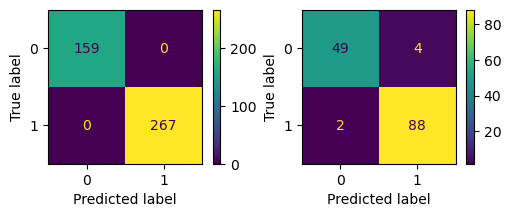

In [24]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,stratify=y)

forest = RandomForestClassifier(n_estimators=500, random_state=42)
forest.fit(X_train, y_train)
y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)
print("Accuracy on train data: {:.2f}".format(forest.score(X_train, y_train)))
print("Accuracy on test data: {:.2f}".format(forest.score(X_test, y_test)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred_train)).plot(ax=ax1);
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(ax=ax2);
plt.show();

### 1.2 Значимость признаков из модели

Попробуем посмотреть важность признаков, которые есть в нашей модели и кроме важности добавим разброс признаков. Идея в следующем, если разброс важности будет большой, то скорее всего признаки коррелируют, так как в разных деревьях, то они важны, то нет.  

,mean,std
worst radius,0.084370,0.198943
mean concave points,0.096553,0.215444
worst concave points,0.124100,0.231186
worst perimeter,0.134587,0.256369
worst area,0.135029,0.247928


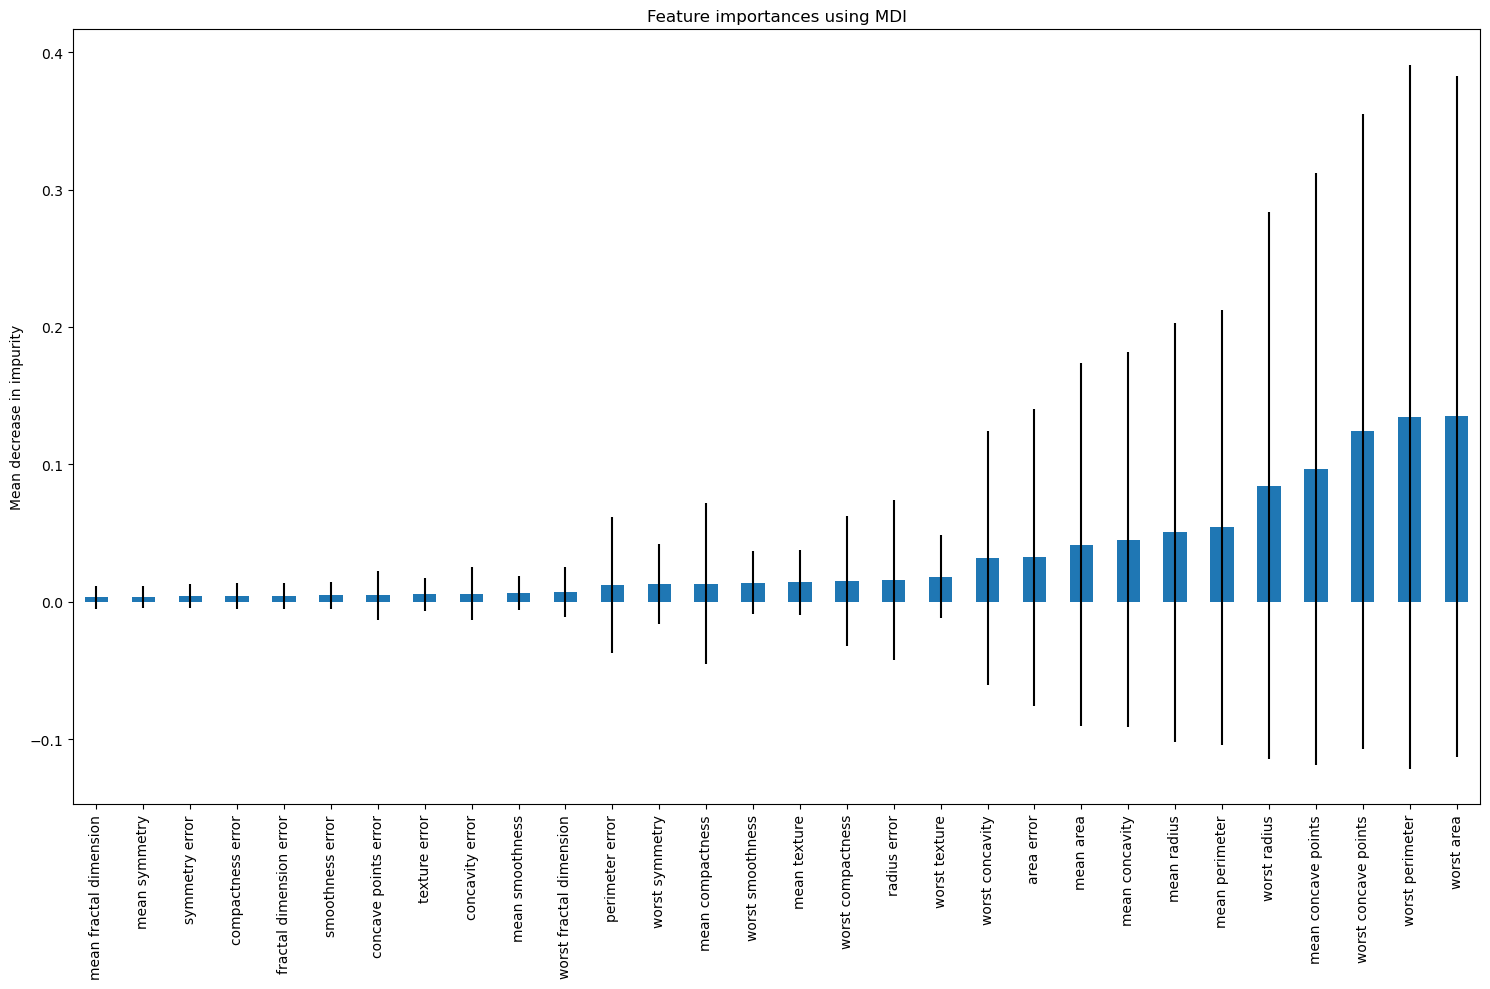

In [19]:
feature_names = cancer.feature_names
forest_importances = pd.DataFrame(forest.feature_importances_, index=feature_names, columns =['mean'])
forest_importances['std'] = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

sort_forest = forest_importances.sort_values(by='mean')


fig, ax = plt.subplots(figsize=(15,10))
col = sort_forest['mean']
yerr = sort_forest['std']
col.plot.bar(yerr=yerr, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

display(sort_forest.tail(5))

У нас очень не устойчивая важность признаков и это плохо, мы не знаем какие реально важны! Дисперсия больше среднего значения значимости признака при перестановке.

### 1.3 Значимость признаков модели с использованием перестановок

Давайте построим график значимости признаков на основе леса и значимости перестановок. 

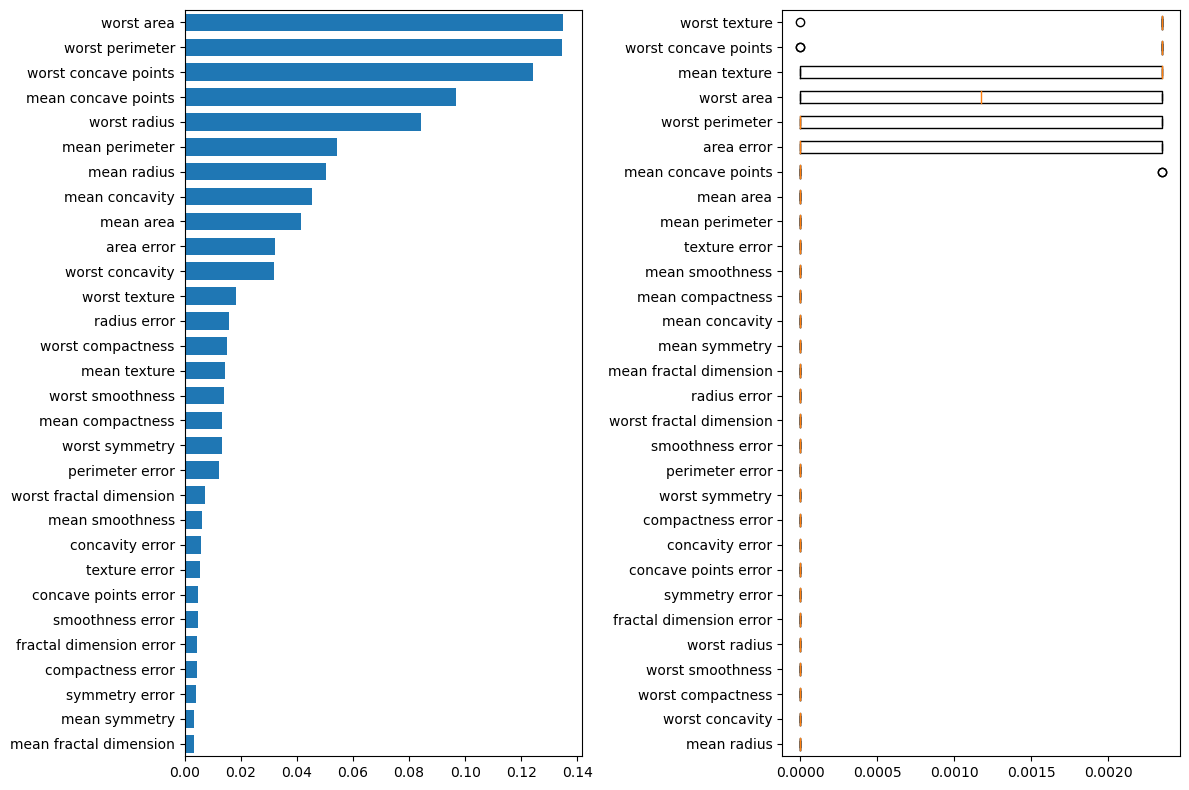

In [20]:
result = permutation_importance(forest, X_train, y_train, n_repeats=10, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(forest.feature_importances_)
tree_indices = np.arange(0, len(forest.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices, forest.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(forest.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

График значимости перестановки показывает, что перестановка признака снижает точность для наиболее важного признака из модели с 0.135 до 0.0025 (в 50 раз!), получается, что ни один из признаков не важен (значимость перестановки рассчитывается на обучающем наборе, чтобы показать, насколько модель зависит от каждого признака во время обучения.)

Это противоречит вычисленной выше высокой точности теста, следовательно какие-то признаки должны быть важными. 

### 2.4. Борьба с коррелированными признаками

Когда признаки коллинеарны, перестановка одного признака мало повлияет на качество модели, поскольку она может получить ту же информацию от другого коррелированного признака. 

Одним из способов обработки мультиколлинеарных признаков является выполнение иерархической кластеризации ранговых корреляций Спирмена, выбор порога и сохранение одного признака из каждого кластера. 

Во-первых, мы строим тепловую карту коррелированных функций:

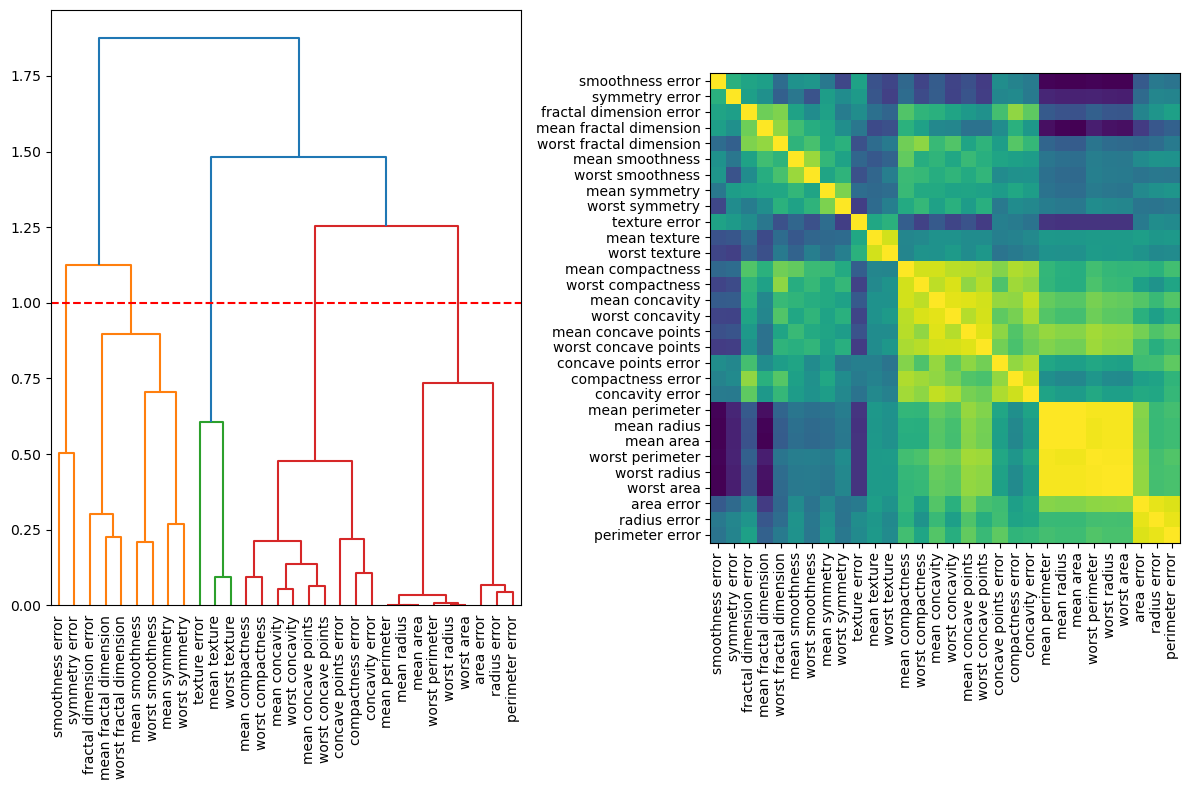

In [7]:
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels = cancer.feature_names,
    ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax1.axhline(y=1, color='r', linestyle='--')


# distance_matrix = 1 - np.abs(corr)
# dist_linkage = hierarchy.ward(squareform(distance_matrix))
# dendro = hierarchy.dendrogram(
#     dist_linkage, 
#     ax=ax2, leaf_rotation=90
# )

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(cancer.feature_names[dendro["leaves"]], rotation="vertical")
ax2.set_yticklabels(cancer.feature_names[dendro["leaves"]])
fig.tight_layout()
plt.show()

Затем мы вручную выбираем порог путем визуального осмотра дендрограммы, чтобы сгруппировать наши признаки в кластеры и выбрать признак из каждого кластера для дальнейшего применения.

Выбрав признаки из нашего набора данных и обучить новый случайный лес. Точность теста нового случайного леса не сильно изменилась по сравнению со случайным лесом, обученным на полном наборе данных.

Точность тестовых данных с удаленными признаками: 0.92


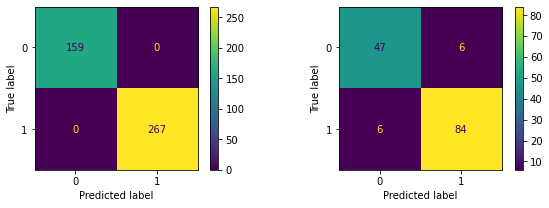

[0, 1, 4, 5, 14]
['mean radius' 'mean texture' 'mean smoothness' 'mean compactness'
 'smoothness error']


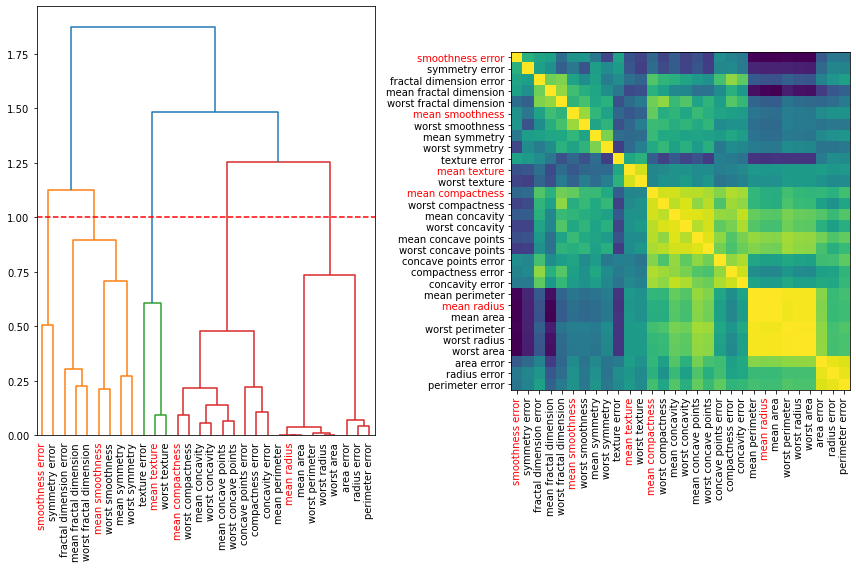

In [6]:
 from collections import defaultdict

cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=210)
clf_sel.fit(X_train_sel, y_train)
print(
    "Точность тестовых данных с удаленными признаками: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)
y_pred_train = clf_sel.predict(X_train_sel)
y_pred = clf_sel.predict(X_test_sel)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred_train)).plot(ax=ax1);
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot(ax=ax2);
plt.show();


selected_features_names = cancer.feature_names[selected_features]


print(selected_features)
print(selected_features_names)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels = cancer.feature_names,
    ax=ax1, leaf_rotation=90
)

ax1.axhline(y=1, color='r', linestyle='--')

[ax1.get_xticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in selected_features];

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(cancer.feature_names[dendro["leaves"]], rotation="vertical")
ax2.set_yticklabels(cancer.feature_names[dendro["leaves"]])
fig.tight_layout()
[ax2.get_xticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in selected_features];
[ax2.get_yticklabels()[dendro["leaves"].index(i)].set_color('red') for i  in selected_features];
plt.show()

Теперь посмотрим значимость признаков и значимость перестановок.

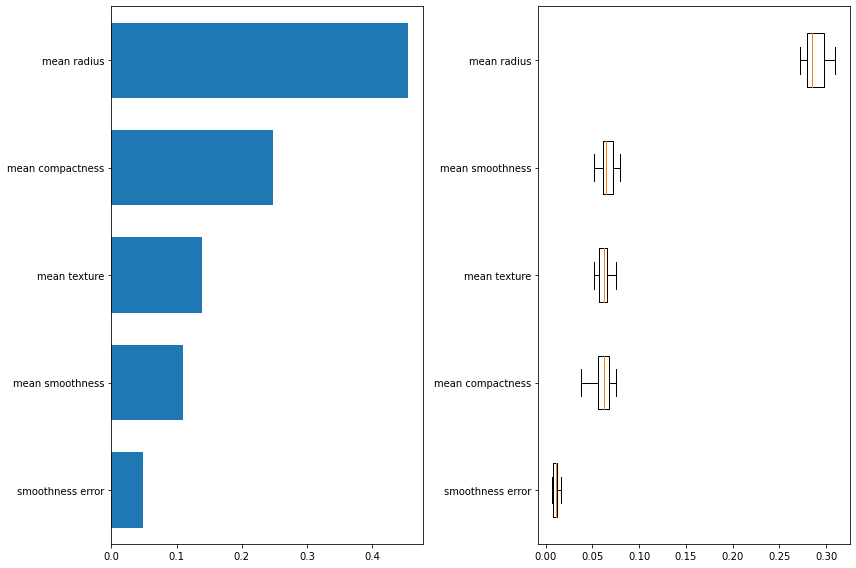

In [7]:
result = permutation_importance(clf_sel, X_train_sel, y_train, n_repeats=10, random_state=42)

perm_sorted_idx = result.importances_mean.argsort()
tree_importance_sorted_idx = np.argsort(clf_sel.feature_importances_)
tree_indices = np.arange(0, len(clf_sel.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

ax1.barh(tree_indices, clf_sel.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(selected_features_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf_sel.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=selected_features_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

Перестановки вызывают падение значимости признаков, и даже меняют их порядок, но нестоль сильно как ранее. Можно сказать, что мы нашли наиболее значимые признаки.

Проверим что с разбросом значений в нашем "усеченном" по признакам лесе.

,mean,std
smoothness error,0.049113,0.030289
mean smoothness,0.109106,0.057974
mean texture,0.139543,0.079148
mean compactness,0.247221,0.164082
mean radius,0.455017,0.178620


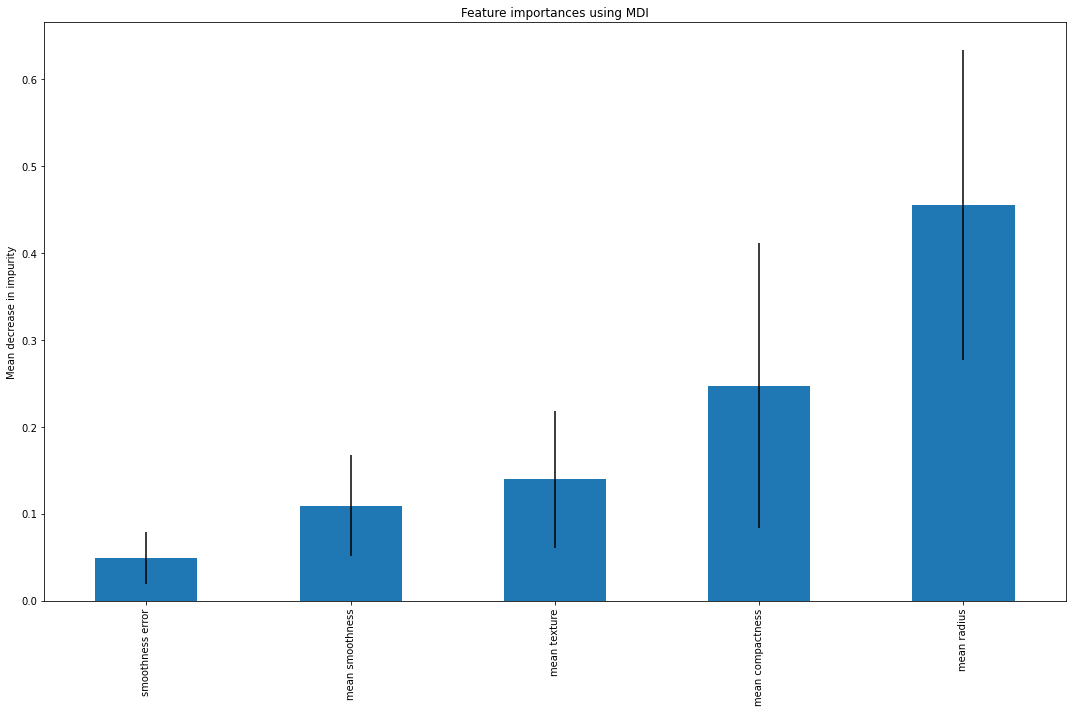

In [8]:
feature_names = selected_features_names[tree_importance_sorted_idx]
forest_importances = pd.DataFrame(clf_sel.feature_importances_, 
                                  index=selected_features_names, 
                                  columns =['mean'])
forest_importances['std'] = np.std([tree.feature_importances_ for tree in clf_sel.estimators_], axis=0)

sort_forest = forest_importances.sort_values(by='mean')


fig, ax = plt.subplots(figsize=(15,10))
col = sort_forest['mean']
yerr = sort_forest['std']
col.plot.bar(yerr=yerr, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

display(sort_forest)

Как ожидалось дисперсия снизилась.

Важно! значимость признаков берется из `permutation_importance` именно там расчитываюся более корректно значимые признаки для данной модели.